# Wright-Fisher Simulations

*in progress*

## Imports / configuration

In [483]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import GPy as gp

sns.set_style("whitegrid")
sns.set_context("talk")

## Functions

In [484]:
def simulate_frequencies(p, n_e, max_gen):
    """Simulate frequencies under the Wright Fisher model
    
    Args
    ----
    p : int
        number of SNPs
    n_e : int
        effective population size
    max_gen : int
        maximum number of generations
    
    Returns
    -------
    F : np.array
        max_gen x p matrix
    
    """
    F = np.empty((max_gen, p))
    F[0, :] = np.random.beta(1., 1., size=p)
    for t in range(1, max_gen):
        F[t, :] = np.random.binomial(2 * n_e, F[t-1, :]) / (2 * n_e)
    
    return(F)

def simulate_genotypes(t, F):
    """Simulate sampled genotypes conditional on 
    full allele frequency trajectories
    
    Args
    ----
    t : np.array
        sorted vector of sampled time points
    F : np.array
        max_gen x p matrix of allele frequency trajectories
    
    Returns
    -------
    X : np.array
        n x p genotype matrix
    """
    F_samp = F[t, :]
    X = np.random.binomial(2, F_samp)
    
    return(X)

def simulate_reads(X, eps, lamb):
    """Simulate read data conditional on the genotypes
    
    Args
    ----
    X : np.array
        n x p genotype matrix
    eps : float
        error probability
    lamb : float
        average coverage 
    
    Returns
    -------
    (Y, C) : tuple
        a tuple of np.arrays where Y is the read count of 
        the counted allele and C is the coverage 
    """
    n, p = X.shape
    C = np.random.poisson(lamb, size=(n, p)) 
    P = X / 2.
    Y = np.random.binomial(C, (eps * P) + ((1. - eps ) * P))
    
    return((Y, C))

def compute_mean_heterozygosity(X):
    """Comptupes an estimate of mean heterozygosity from 
    the genotype data
    
    Args
    ----
    X : np.array
        n x p genotype matrix
    
    Returns
    -------
    h_hat : np.array
        estimate of mean heterozygosity for each sampled time 
        point
    """
    n, p = X.shape
    h_hat = np.sum(X==1, axis=1) / p
    
    return(h_hat)  

## Simulation

In [526]:
# simulate frequency trajectories
p = 10000 # number of SNPs
n_e = 5000 # effective population size
max_gen = 700 # 
F = simulate_frequencies(p, n_e, max_gen)

# simulate genotypes
n = 20
t = np.sort(np.random.choice(range(F.shape[0]), size=n, replace=False))
X = simulate_genotypes(t, F)

# simulate reads
eps = .01
lamb = .5
Y, C = simulate_reads(X, eps, lamb)

Plot a hist of the coverage distribution for a the first individual

Text(0,0.5,'Count')

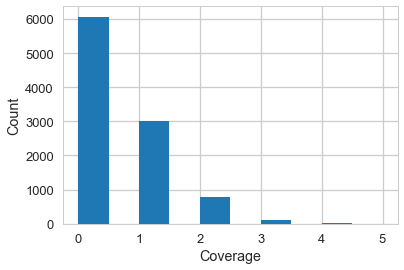

In [528]:
plt.hist(C[0,:]);
plt.xlabel("Coverage")
plt.ylabel("Count")

Plot some example trajectories

Text(0,0.5,'Allele Frequency')

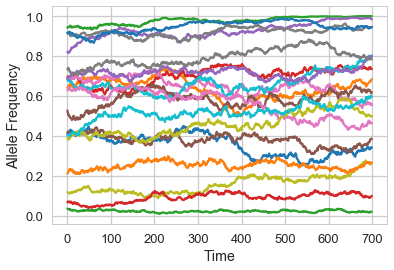

In [509]:
idx = np.sort(np.random.choice(range(p), size=20, replace=False))
for j in idx:
    plt.plot(range(max_gen), F[:,j])
    
plt.xlabel("Time")
plt.ylabel("Allele Frequency")

Compute the population heterozygosity

In [510]:
H = 2 * F * (1 - F) # for all time points
h_true = np.sum(H, axis=1) / p
h = h_true[t] # for sampled time points

Compute an estimate of heterozygosity from genotypes

In [511]:
h_hat = compute_mean_heterozygosity(X)

Plot population heterozygosity against time

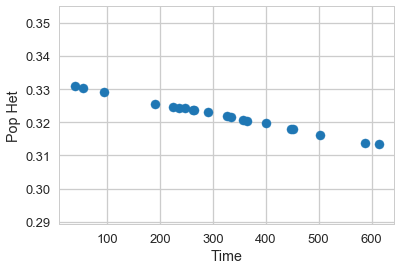

In [512]:
plt.scatter(t, h)
plt.xlabel("Time");
plt.ylabel("Pop Het");

Plot estimated heterozygosity against time

Text(0,0.5,'Estimted Het')

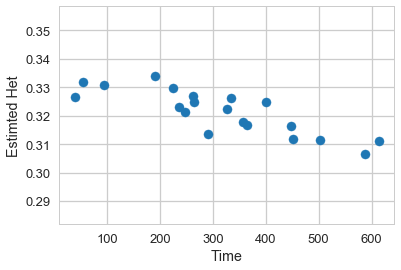

In [513]:
plt.scatter(t, h_hat)
plt.xlabel("Time")
plt.ylabel("Estimted Het")

## Inference

Use a gaussian process with a Matern kernal using an emprical Bayes approach where the marginal likelihood is maxize to estimate hyper parameters of the covariance kernal and the posterior is then analytically computed ...

In [514]:
kern = gp.kern.Matern52(1) 
model = gp.models.GPRegression(t[:,None], h_hat[:,None], kern)

# fixing the noise variance
h_mod = H[-1,:]
sigma2_e = np.sum(h_mod * (1. - h_mod)) / p**2
model[".*Gaussian_noise"] = sigma2_e 
model['.*Gaussian_noise'].fix()

In [515]:
%%time
model.optimize()
model_df = pd.DataFrame({"Posterior Mean": model.posterior.mean[:,0], "Pop Het":h, "Est Het": h_hat})

CPU times: user 65.9 ms, sys: 57 µs, total: 65.9 ms
Wall time: 66 ms


Fitting this is incredibly quick!

## Critique

Here is a plot of the posterior mean and variance output by the analytical posterior of the Gaussian Process model

 /project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


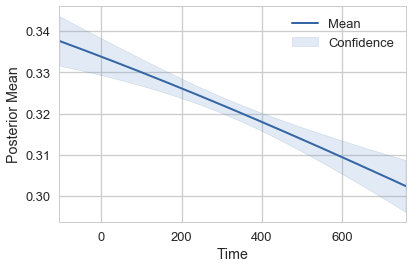

In [516]:
model.plot_f();
plt.xlabel("Time");
plt.ylabel("Posterior Mean");

Here is a plot of the posterior mean against the population heterozygosity

0.998104752335005

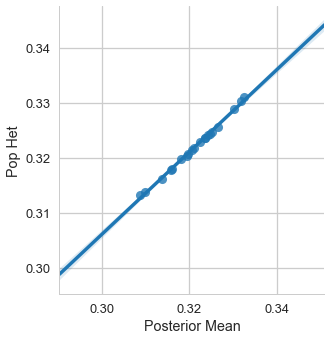

In [517]:
sns.lmplot(x="Posterior Mean", y="Pop Het", data=model_df)
np.corrcoef(model_df["Posterior Mean"], model_df["Pop Het"])[0,1]

Here is a plot of the naive heterozygosity estimate

0.832752047270508

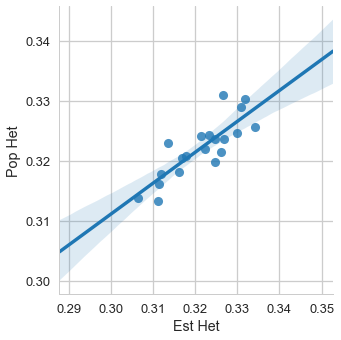

In [518]:
sns.lmplot(x="Est Het", y="Pop Het", data=model_df)
np.corrcoef(model_df["Est Het"], model_df["Pop Het"])[0,1]

Here are the fitted kernal parameters

In [519]:
model.kern

Mat52.,value,constraints,priors
variance,0.08955348971322616,+ve,
lengthscale,8722.052582558987,+ve,


It seems the GP does provides a better fit than just the naive approach of computing the MLE of heterozygosity from the genotypes!